In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import imblearn
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import shap

import warnings
warnings.filterwarnings('ignore')

rs=7

# Country

## data loading

In [120]:
df = pd.read_csv('df_country_3.csv')
df.shape

(218064, 105)

In [121]:
df.head(2)

,LOAN_AMOUNT,STATUS,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,POSTED_DATE,LEN_DESCRIPTION,LEN_TAGS,Agriculture,Arts,Clothing,Construction,Education,Entertainment,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale,Albania,Armenia,Bangladesh,Bolivia,Brazil,Burkina Faso,Cambodia,Cameroon,Colombia,Congo,Costa Rica,Dominican Republic,Ecuador,Egypt,El Salvador,Fiji,Georgia,Ghana,Guatemala,Haiti,Honduras,India,Indonesia,Israel,Jordan,Kenya,Kosovo,Kyrgyzstan,Lebanon,Lesotho,Liberia,Madagascar,Malawi,Mali,Mexico,Moldova,Mozambique,Namibia,Nepal,Nicaragua,Nigeria,Pakistan,Palestine,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Puerto Rico,Rwanda,Samoa,Senegal,Sierra Leone,Solomon Islands,Tajikistan,Tanzania,Thailand,The Democratic Republic of the Congo,Timor-Leste,Togo,Tonga,Turkey,Uganda,United States,Vietnam,Zambia,Zimbabwe,DAYS_TO_EXPIRE,MALE_BORROWERS,FEMALE_BORROWERS,partner_rating,time_on_kiva,total_loans,are_interest_fees_charged,avg_cost_to_borrower,profitability_ROA,avg_loan_size,delinquency_rate,loans_at_risk_rate,default_rate,emo_score
0,1100.0,1,14.0,4,1,1,2019-08-19,617,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,31.0,1,0,2.5,131.0,15029975.0,1,47.0,1.0,66.7,31.72,45.79,0.61,0.7845
1,500.0,1,14.0,4,1,1,2019-01-24,334,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32.0,0,1,2.0,140.0,15969225.0,1,36.0,4.0,34.9,8.28,10.96,2.78,0.9423


In [122]:
df.STATUS.value_counts()

0    203007
1     15057
Name: STATUS, dtype: int64

In [123]:
X = df.drop(columns=['STATUS','POSTED_DATE'])
y = df.STATUS

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

## No oversampling

### DT

In [124]:
# build pipeline
sscaler = StandardScaler()
dt = DecisionTreeClassifier(random_state=rs)

pipe = make_pipeline(sscaler, dt)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=7))])

In [125]:
# set parameters for GridSearch tunning
dt_params = {
    'decisiontreeclassifier__criterion': ['gini','entropy'],
    'decisiontreeclassifier__max_depth': [3,4,5,6,7,8] 
}

In [126]:
grid = GridSearchCV(pipe, dt_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8}
0.8501310168973507
0.7186969799796402
roc_auc_score 0.8422896770263136
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     40602
           1       0.73      0.70      0.72      3011

    accuracy                           0.96     43613
   macro avg       0.86      0.84      0.85     43613
weighted avg       0.96      0.96      0.96     43613



In [127]:
pred_20q1 = pd.read_csv('test_2020.csv')
del pred_20q1['Unnamed: 0']
pred_20q1.head(5)

,LOAN_ID,LOAN_AMOUNT,STATUS,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,POSTED_DATE,LEN_DESCRIPTION,LEN_TAGS,Agriculture,Arts,Clothing,Construction,Education,Entertainment,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale,Albania,Armenia,Bangladesh,Bolivia,Brazil,Burkina Faso,Cambodia,Cameroon,Colombia,Congo,Costa Rica,Dominican Republic,Ecuador,Egypt,El Salvador,Fiji,Georgia,Ghana,Guatemala,Haiti,Honduras,India,Indonesia,Israel,Jordan,Kenya,Kosovo,Kyrgyzstan,Lebanon,Lesotho,Liberia,Madagascar,Malawi,Mali,Mexico,Moldova,Mozambique,Namibia,Nepal,Nicaragua,Nigeria,Pakistan,Palestine,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Puerto Rico,Rwanda,Samoa,Senegal,Sierra Leone,Solomon Islands,Tajikistan,Tanzania,Thailand,The Democratic Republic of the Congo,Timor-Leste,Togo,Tonga,Turkey,Uganda,United States,Vietnam,Zambia,Zimbabwe,DAYS_TO_EXPIRE,MALE_BORROWERS,FEMALE_BORROWERS,partner_rating,time_on_kiva,total_loans,are_interest_fees_charged,avg_cost_to_borrower,profitability_ROA,avg_loan_size,delinquency_rate,loans_at_risk_rate,default_rate,emo_score
0,1934382,375.0,0,13.0,0,1,0,2020-02-22,3,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54.0,0,0,4.5,139,83612050,1,46.0,6.6,5.7,4.03,11.54,0.02,0.0000
1,1913037,925.0,1,17.0,18,1,1,2020-01-16,684,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.0,0,1,3.0,122,20210350,1,33.0,3.3,24.9,15.94,39.02,8.41,0.8910
2,1920068,1000.0,0,13.0,1,1,0,2020-01-30,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45.0,0,0,2.5,147,18416350,1,21.0,3.6,15.9,72.80,94.75,0.35,0.0000
3,1916675,1425.0,1,23.0,10,2,1,2020-01-23,511,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.0,1,0,4.0,118,11530400,1,37.0,17.1,13.3,17.97,49.48,0.52,0.9217
4,1920354,950.0,1,41.0,0,1,1,2020-01-30,299,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,46.0,1,0,2.5,131,15029975,1,47.0,1.0,66.7,31.72,45.79,0.61,0.8176


In [129]:
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=7))])

In [128]:
X_20q1 = pred_20q1.drop(columns=['STATUS','POSTED_DATE','LOAN_ID'])
y_pred_20q1 = grid.best_estimator_.predict(X_20q1)
print('roc_auc_score', roc_auc_score(pred_20q1.STATUS, y_pred_20q1))
print(classification_report(pred_20q1.STATUS, y_pred_20q1))

roc_auc_score 0.8352120061211086
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49191
           1       0.17      0.69      0.28       290

    accuracy                           0.98     49481
   macro avg       0.59      0.84      0.63     49481
weighted avg       0.99      0.98      0.99     49481



#### importance

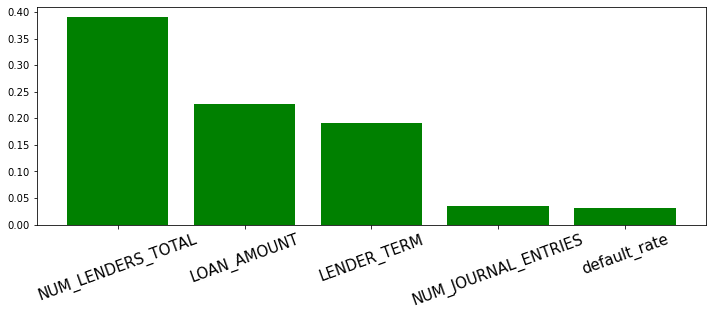

In [102]:
# get importance
importance = grid.best_estimator_.steps[1][1].feature_importances_

# identify the top 20 important features for Decision tree model
max_inx = (-importance).argsort()[:5]
feature_top5 = X_test.columns[max_inx]

# plot feature importance - top 20
plt.figure(figsize=(12, 4))
plt.bar(feature_top5, importance[max_inx], color=['green'])
plt.xticks(rotation=20, fontsize=15)
plt.show()

### RF

In [20]:
# build pipeline
sscaler = StandardScaler()
rf = RandomForestClassifier(random_state=rs)

pipe = make_pipeline(sscaler, rf)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=7))])

In [21]:
# set parameters for GridSearch tunning
rf_params = {
    'randomforestclassifier__criterion': ['gini','entropy'],
    'randomforestclassifier__max_depth': [3,4,5,6,7,8],
    'randomforestclassifier__min_samples_split': [3,4,5],
    'randomforestclassifier__n_estimators': [100,150]
}

In [22]:
grid = RandomizedSearchCV(pipe, rf_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'gini'}
0.5477979615400906
0.07402680280791321
roc_auc_score 0.5191765007706746
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     40602
           1       0.94      0.04      0.07      3011

    accuracy                           0.93     43613
   macro avg       0.94      0.52      0.52     43613
weighted avg       0.93      0.93      0.90     43613



In [23]:
confusion_matrix(y_test, y_pred)

array([[40595,     7],
       [ 2895,   116]], dtype=int64)

### XGB

In [26]:
# build pipeline
sscaler = StandardScaler()
xgb = XGBClassifier(random_state=rs, verbosity = 0)

pipe = make_pipeline(sscaler, xgb)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=7, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=0))])

In [2]:
# set parameters for GridSearch tunning
xgb_params = {
    'xgbclassifier__n_estimators':[100,150],
    'xgbclassifier__learning_rate': [0.001, 0.01, 1],
    'xgbclassifier__max_depth':[5,10,15]
}

In [28]:
grid = RandomizedSearchCV(pipe, xgb_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 15, 'xgbclassifier__learning_rate': 1}
0.8855192804843657
0.7876135981151128
roc_auc_score 0.8812972575753835
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     40602
           1       0.80      0.78      0.79      3011

    accuracy                           0.97     43613
   macro avg       0.89      0.88      0.89     43613
weighted avg       0.97      0.97      0.97     43613



## Oversampling

### DT

In [29]:
# build pipeline - using RandomOverSampling to oversample
sscaler = StandardScaler()
ros = RandomOverSampler(random_state=rs)
dt = DecisionTreeClassifier(random_state=rs)

pipe_ros = make_pipeline(sscaler, ros, dt)
pipe_ros

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=7))])

In [30]:
grid = GridSearchCV(pipe_ros, dt_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8}
0.7646046139172455
0.5784839591134501
roc_auc_score 0.9251867252384984
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     40602
           1       0.42      0.95      0.58      3011

    accuracy                           0.90     43613
   macro avg       0.71      0.93      0.76     43613
weighted avg       0.96      0.90      0.92     43613



### RF

In [31]:
# build pipeline - using SMOTE to oversample
sscaler = StandardScaler()
ros = RandomOverSampler(random_state=rs)
rf = RandomForestClassifier(random_state=rs)

pipe_ros = make_pipeline(sscaler, ros, rf)
pipe_ros

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=7))])

In [32]:
grid = RandomizedSearchCV(pipe_ros, rf_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'gini'}
0.6570690199219748
0.425948223961469
roc_auc_score 0.8782362352931784
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     40602
           1       0.28      0.94      0.43      3011

    accuracy                           0.83     43613
   macro avg       0.63      0.88      0.66     43613
weighted avg       0.94      0.83      0.86     43613



### XGB

In [13]:
# build pipeline
sscaler = StandardScaler()
ros = RandomOverSampler(random_state=rs)
xgb = XGBClassifier(random_state=rs,verbosity = 0)

pipe_ros = make_pipeline(sscaler, ros, xgb)
pipe_ros

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=7, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, valid

In [14]:
grid = RandomizedSearchCV(pipe_ros, xgb_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 15, 'xgbclassifier__learning_rate': 1}
0.887824197302655
0.7969682309304951
roc_auc_score 0.9014745507871398
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     40602
           1       0.77      0.82      0.80      3011

    accuracy                           0.97     43613
   macro avg       0.88      0.90      0.89     43613
weighted avg       0.97      0.97      0.97     43613



#### SHAP

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ros = RandomOverSampler(random_state=7)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

my_model = XGBClassifier(random_state=rs,verbosity = 0, n_estimators=150, 
                         max_depth=15, learning_rate=1).fit(X_resampled, y_resampled)
explainer = shap.TreeExplainer(my_model)

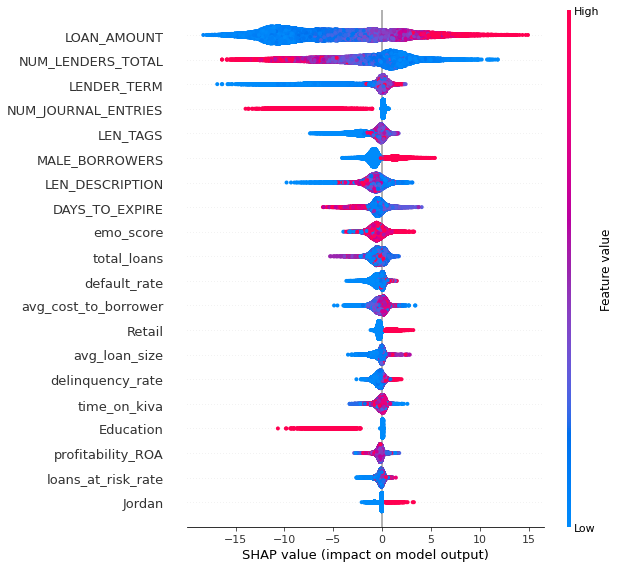

In [19]:
# global interpretability
# Make plot. Index of [1] is explained in text below.
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names = X_test.columns)

#### Error analysis

In [23]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
join = X_test.copy()
join['status'] = y_test
join['pred'] = y_pred
join['accuracy'] = join['status'] + join['pred']
join.head(2)

,LOAN_AMOUNT,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,LEN_DESCRIPTION,LEN_TAGS,Agriculture,Arts,Clothing,Construction,Education,Entertainment,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale,Albania,Armenia,Bangladesh,Bolivia,Brazil,Burkina Faso,Cambodia,Cameroon,Colombia,Congo,Costa Rica,Dominican Republic,Ecuador,Egypt,El Salvador,Fiji,Georgia,Ghana,Guatemala,Haiti,Honduras,India,Indonesia,Israel,Jordan,Kenya,Kosovo,Kyrgyzstan,Lebanon,Lesotho,Liberia,Madagascar,Malawi,Mali,Mexico,Moldova,Mozambique,Namibia,Nepal,Nicaragua,Nigeria,Pakistan,Palestine,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Puerto Rico,Rwanda,Samoa,Senegal,Sierra Leone,Solomon Islands,Tajikistan,Tanzania,Thailand,The Democratic Republic of the Congo,Timor-Leste,Togo,Tonga,Turkey,Uganda,United States,Vietnam,Zambia,Zimbabwe,DAYS_TO_EXPIRE,MALE_BORROWERS,FEMALE_BORROWERS,partner_rating,time_on_kiva,total_loans,are_interest_fees_charged,avg_cost_to_borrower,profitability_ROA,avg_loan_size,delinquency_rate,loans_at_risk_rate,default_rate,emo_score,status,pred,accuracy
27213,575.0,8.0,8,1,1,1011,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.0,0,1,3.5,133.0,16742025.0,0,39.0,3.3,15.9,7.66,11.54,0.28,0.9799,0,0,0
202842,1200.0,13.0,24,1,1,576,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.0,1,0,3.0,54.0,1921925.0,1,31.0,0.4,15.9,3.82,3.87,0.25,0.9186,0,0,0


In [29]:
join.accuracy.value_counts()

0    39883
2     2471
1     1259
Name: accuracy, dtype: int64

##### gender

In [52]:
join['FEMALE_BORROWERS'].value_counts(normalize=True)

1    0.784972
0    0.215028
Name: FEMALE_BORROWERS, dtype: float64

In [54]:
# check gender bias - male
male = join[join['MALE_BORROWERS']==1]
male['accuracy'].value_counts(normalize=True)

0    0.812054
2    0.134592
1    0.053354
Name: accuracy, dtype: float64

In [88]:
# check gender bias - female
female = join[join['FEMALE_BORROWERS']==1]
female['accuracy'].value_counts(normalize=True)

0    0.939243
2    0.030933
1    0.029823
Name: accuracy, dtype: float64

##### sector

In [91]:
sector_lst = ['Arts','Clothing','Construction','Education','Entertainment','Food','Health','Housing',
              'Manufacturing','Personal Use','Retail','Services','Transportation','Wholesale']
sector = pd.DataFrame()

sector['correct'] = 0.0
sector['wrong'] = 0.0
sector['sector'] = sector_lst
sector = sector.set_index('sector')

for i in sector_lst:
    df_sector = join[join[i]==1]
    try:
        sector.loc[i]['wrong'] = df_sector['accuracy'].value_counts(normalize=True)[1]
    except:
        pass
    try:
        sector.loc[i]['correct'] = df_sector['accuracy'].value_counts(normalize=True)[0]
    except:
        pass
    try:
        sector.loc[i]['correct'] = sector.loc[i]['correct']+df_sector['accuracy'].value_counts(normalize=True)[2]
    except:
        pass
sector

,correct,wrong
sector,,
Arts,0.989937,0.010063
Clothing,0.959920,0.040080
Construction,0.946860,0.053140
Education,0.981518,0.018482
Entertainment,1.000000,NaN
Food,0.958505,0.041495
Health,0.933962,0.066038
Housing,0.985465,0.014535
Manufacturing,0.989510,0.010490


#### prediction of 20Q1 underfunded

In [115]:
pred_20q1 = pd.read_csv('test_2020.csv')
del pred_20q1['Unnamed: 0']
pred_20q1.head(5)

,LOAN_ID,LOAN_AMOUNT,STATUS,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,POSTED_DATE,LEN_DESCRIPTION,LEN_TAGS,Agriculture,Arts,Clothing,Construction,Education,Entertainment,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale,Albania,Armenia,Bangladesh,Bolivia,Brazil,Burkina Faso,Cambodia,Cameroon,Colombia,Congo,Costa Rica,Dominican Republic,Ecuador,Egypt,El Salvador,Fiji,Georgia,Ghana,Guatemala,Haiti,Honduras,India,Indonesia,Israel,Jordan,Kenya,Kosovo,Kyrgyzstan,Lebanon,Lesotho,Liberia,Madagascar,Malawi,Mali,Mexico,Moldova,Mozambique,Namibia,Nepal,Nicaragua,Nigeria,Pakistan,Palestine,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Puerto Rico,Rwanda,Samoa,Senegal,Sierra Leone,Solomon Islands,Tajikistan,Tanzania,Thailand,The Democratic Republic of the Congo,Timor-Leste,Togo,Tonga,Turkey,Uganda,United States,Vietnam,Zambia,Zimbabwe,DAYS_TO_EXPIRE,MALE_BORROWERS,FEMALE_BORROWERS,partner_rating,time_on_kiva,total_loans,are_interest_fees_charged,avg_cost_to_borrower,profitability_ROA,avg_loan_size,delinquency_rate,loans_at_risk_rate,default_rate,emo_score
0,1934382,375.0,0,13.0,0,1,0,2020-02-22,3,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54.0,0,0,4.5,139,83612050,1,46.0,6.6,5.7,4.03,11.54,0.02,0.0000
1,1913037,925.0,1,17.0,18,1,1,2020-01-16,684,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.0,0,1,3.0,122,20210350,1,33.0,3.3,24.9,15.94,39.02,8.41,0.8910
2,1920068,1000.0,0,13.0,1,1,0,2020-01-30,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45.0,0,0,2.5,147,18416350,1,21.0,3.6,15.9,72.80,94.75,0.35,0.0000
3,1916675,1425.0,1,23.0,10,2,1,2020-01-23,511,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.0,1,0,4.0,118,11530400,1,37.0,17.1,13.3,17.97,49.48,0.52,0.9217
4,1920354,950.0,1,41.0,0,1,1,2020-01-30,299,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,46.0,1,0,2.5,131,15029975,1,47.0,1.0,66.7,31.72,45.79,0.61,0.8176


In [116]:
pred_20q1['STATUS'].value_counts()

0    49191
1      290
Name: STATUS, dtype: int64

In [117]:
X_20q1 = pred_20q1.drop(columns=['STATUS','POSTED_DATE','LOAN_ID'])
y_pred_20q1 = grid.best_estimator_.predict(X_20q1)
print('roc_auc_score', roc_auc_score(pred_20q1.STATUS, y_pred_20q1))
print(classification_report(pred_20q1.STATUS, y_pred_20q1))

roc_auc_score 0.8352120061211086
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49191
           1       0.17      0.69      0.28       290

    accuracy                           0.98     49481
   macro avg       0.59      0.84      0.63     49481
weighted avg       0.99      0.98      0.99     49481



In [118]:
pred_20q1['predict']=y_pred_20q1
pred_20q1.head(2)

,LOAN_ID,LOAN_AMOUNT,STATUS,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,POSTED_DATE,LEN_DESCRIPTION,LEN_TAGS,Agriculture,Arts,Clothing,Construction,Education,Entertainment,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale,Albania,Armenia,Bangladesh,Bolivia,Brazil,Burkina Faso,Cambodia,Cameroon,Colombia,Congo,Costa Rica,Dominican Republic,Ecuador,Egypt,El Salvador,Fiji,Georgia,Ghana,Guatemala,Haiti,Honduras,India,Indonesia,Israel,Jordan,Kenya,Kosovo,Kyrgyzstan,Lebanon,Lesotho,Liberia,Madagascar,Malawi,Mali,Mexico,Moldova,Mozambique,Namibia,Nepal,Nicaragua,Nigeria,Pakistan,Palestine,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Puerto Rico,Rwanda,Samoa,Senegal,Sierra Leone,Solomon Islands,Tajikistan,Tanzania,Thailand,The Democratic Republic of the Congo,Timor-Leste,Togo,Tonga,Turkey,Uganda,United States,Vietnam,Zambia,Zimbabwe,DAYS_TO_EXPIRE,MALE_BORROWERS,FEMALE_BORROWERS,partner_rating,time_on_kiva,total_loans,are_interest_fees_charged,avg_cost_to_borrower,profitability_ROA,avg_loan_size,delinquency_rate,loans_at_risk_rate,default_rate,emo_score,predict
0,1934382,375.0,0,13.0,0,1,0,2020-02-22,3,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54.0,0,0,4.5,139,83612050,1,46.0,6.6,5.7,4.03,11.54,0.02,0.000,0
1,1913037,925.0,1,17.0,18,1,1,2020-01-16,684,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.0,0,1,3.0,122,20210350,1,33.0,3.3,24.9,15.94,39.02,8.41,0.891,0


In [119]:
pred_20q1.to_csv('pred_20q1.csv', index=False)

# Continent

## data loading

In [2]:
df = pd.read_csv('df_continent_3.csv')
df.shape

(218064, 44)

In [3]:
df.head(2)

,LOAN_AMOUNT,STATUS,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,POSTED_DATE,LEN_DESCRIPTION,LEN_TAGS,Agriculture,...,delinquency_rate,loans_at_risk_rate,default_rate,emo_score,Africa,Asia,North America,Europe,South America,Oceania
0,1100.0,1,14.0,4,1,1,2019-08-19,617,8,0,...,31.72,45.79,0.61,0.7845,1,0,0,0,0,0
1,500.0,1,14.0,4,1,1,2019-01-24,334,5,0,...,8.28,10.96,2.78,0.9423,1,0,0,0,0,0


In [4]:
X = df.drop(columns=['STATUS','POSTED_DATE'])
y = df.STATUS

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

## No oversampling

### DT

In [36]:
# build pipeline
sscaler = StandardScaler()
dt = DecisionTreeClassifier(random_state=rs)

pipe = make_pipeline(sscaler, dt)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=7))])

In [37]:
grid = GridSearchCV(pipe, dt_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8}
0.8511652215442744
0.7188612099644128
roc_auc_score 0.8427385917334355
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     40602
           1       0.73      0.70      0.72      3011

    accuracy                           0.96     43613
   macro avg       0.86      0.84      0.85     43613
weighted avg       0.96      0.96      0.96     43613



### RF

In [5]:
# build pipeline
sscaler = StandardScaler()
rf = RandomForestClassifier(random_state=rs)

pipe = make_pipeline(sscaler, rf)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=7))])

In [10]:
grid = RandomizedSearchCV(pipe, rf_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'gini'}
0.6664241386741255
0.36426482318532305
roc_auc_score 0.6129491316758835
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     40602
           1       0.91      0.23      0.36      3011

    accuracy                           0.95     43613
   macro avg       0.93      0.61      0.67     43613
weighted avg       0.94      0.95      0.93     43613



### XGB

In [11]:
# build pipeline
sscaler = StandardScaler()
xgb = XGBClassifier(random_state=rs, verbosity = 0)

pipe = make_pipeline(sscaler, xgb)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=7, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=0))])

In [12]:
grid = RandomizedSearchCV(pipe, xgb_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 15, 'xgbclassifier__learning_rate': 1}
0.8875159785918688
0.7930917710802573
roc_auc_score 0.8820973303950895
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     40602
           1       0.81      0.78      0.79      3011

    accuracy                           0.97     43613
   macro avg       0.90      0.88      0.89     43613
weighted avg       0.97      0.97      0.97     43613



## Oversampling

### DT

In [38]:
# build pipeline - using RandomOverSampling to oversample
sscaler = StandardScaler()
ros = RandomOverSampler(random_state=rs)
dt = DecisionTreeClassifier(random_state=rs)

pipe_ros = make_pipeline(sscaler, ros, dt)
pipe_ros

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=7))])

In [39]:
grid = GridSearchCV(pipe_ros, dt_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8}
0.7644893150625324
0.578245046502224
roc_auc_score 0.9254080088359987
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     40602
           1       0.42      0.95      0.58      3011

    accuracy                           0.90     43613
   macro avg       0.71      0.93      0.76     43613
weighted avg       0.96      0.90      0.92     43613



### RF

In [40]:
# build pipeline - using SMOTE to oversample
sscaler = StandardScaler()
ros = RandomOverSampler(random_state=rs)
rf = RandomForestClassifier(random_state=rs)

pipe_ros = make_pipeline(sscaler, ros, rf)
pipe_ros

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=7))])

In [41]:
grid = RandomizedSearchCV(pipe_ros, rf_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'gini'}
0.6921382523171016
0.4782104391052196
roc_auc_score 0.9032243537484211
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     40602
           1       0.32      0.96      0.48      3011

    accuracy                           0.86     43613
   macro avg       0.66      0.90      0.70     43613
weighted avg       0.95      0.86      0.89     43613



### XGB

In [13]:
# build pipeline
sscaler = StandardScaler()
ros = RandomOverSampler(random_state=rs)
xgb = XGBClassifier(random_state=rs,verbosity = 0)

pipe_ros = make_pipeline(sscaler, ros, xgb)
pipe_ros

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=7, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, valid

In [14]:
grid = RandomizedSearchCV(pipe_ros, xgb_params, scoring='f1_macro')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

y_pred = grid.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 15, 'xgbclassifier__learning_rate': 1}
0.8898868253085276
0.7888459058671824
roc_auc_score 0.8971566679363328
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     40602
           1       0.77      0.81      0.79      3011

    accuracy                           0.97     43613
   macro avg       0.88      0.90      0.89     43613
weighted avg       0.97      0.97      0.97     43613

